In [1]:
import json
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

from Project_Gas_Library import f_EIA_ListSeries, f_EIA_ExtractData, f_PlotData, f_EIA_PlotData, f_EIA_PlotData_Mod,\
f_WorldWeather_ExtractData, f_PlotData, f_Census_ExtractData, calculate_color, f_strToDate, f_EIA_ExtractData_Range, \
f_EIA_PlotData_Range, f_EIA_PlotData_Mod_Range, f_EIA_PlotData_Stack_Range

#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf, adfuller, kpss
from statsmodels.tsa.arima_model import ARIMA

#from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

from datetime import datetime
from dateutil.relativedelta import relativedelta
from calendar import monthrange

from config import worldweather_key, g_key, EIA_key, census_key

from matplotlib.pyplot import cm
from citipy import citipy
from pprint import pprint

from matplotlib.cm import viridis
from matplotlib.colors import to_hex

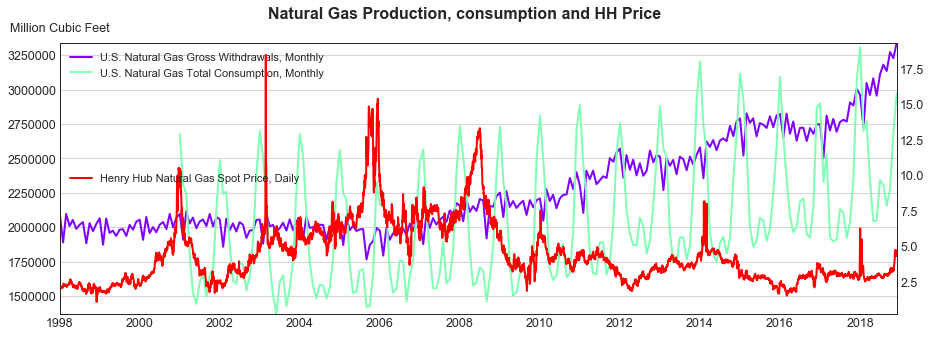

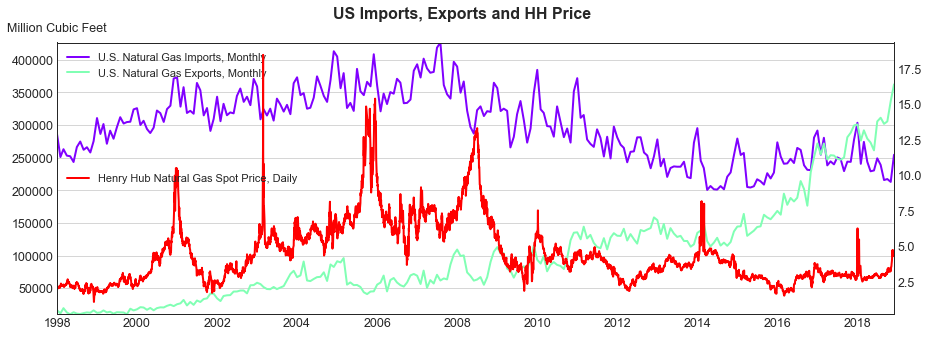

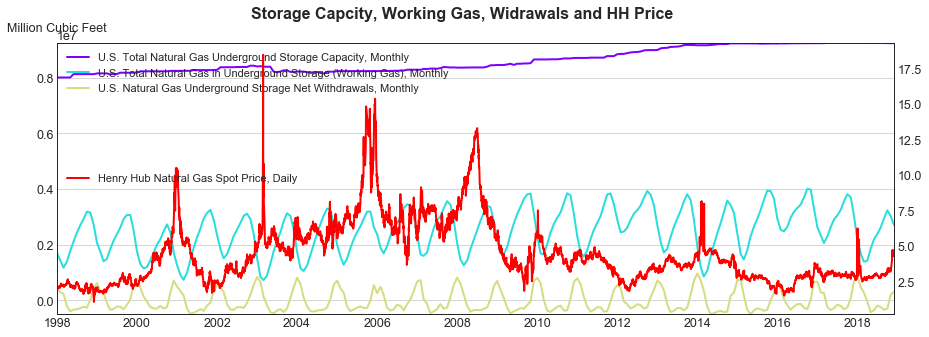

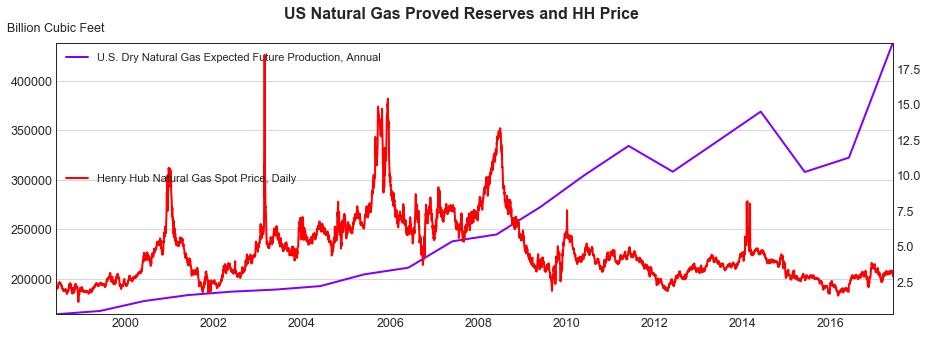

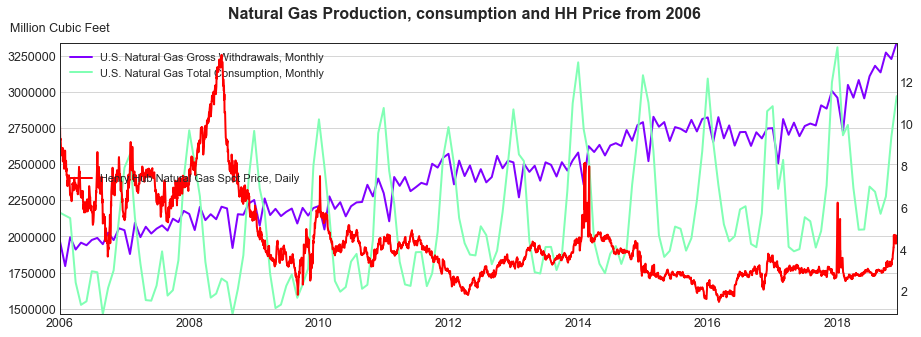

In [2]:
#Defining variables to extract data from EIA
eia_api_key = EIA_key
url = "http://api.eia.gov/series/"

Price_series_id =["NG.RNGWHHD.D"] # HH Prices
Volume_series_id = ["NG.N9010US2.M","NG.N9140US2.M"] # Total Widrawals Consumption

ImpEx_series_id = [ "NG.N9100US2.M", "NG.N9130US2.M"] # Import and Exports

Storage_series_id = ["NG.N5290US2.M","NG.N5020US2.M","NG.N5070US2.M"]
#Capacity, working gas, witdrawals

Reserves_series_id = ["NG.RNGR11NUS_1.A"]

ini_date = "1998-1-1"
end_date = "2018-12-31"

#Extracting and Ploting data from EIA
title = "Natural Gas Production, consumption and HH Price"
f_EIA_PlotData_Mod_Range(Volume_series_id,Price_series_id,url,eia_api_key,title,ini_date,end_date)
FileName = "Figures-Presentation/" + title + ".png"
plt.savefig(FileName)
plt.show()

#Extracting and Ploting data from EIA
title = "US Imports, Exports and HH Price"
f_EIA_PlotData_Mod_Range(ImpEx_series_id,Price_series_id,url,eia_api_key,title,ini_date,end_date)
FileName = "Figures-Presentation/" + title + ".png"
plt.savefig(FileName)
plt.show()

#Extracting and Ploting data from EIA
title = "Storage Capcity, Working Gas, Widrawals and HH Price"
f_EIA_PlotData_Mod_Range(Storage_series_id,Price_series_id,url,eia_api_key,title,ini_date,end_date)
FileName = "Figures-Presentation/" + title + ".png"
plt.savefig(FileName)
plt.show()

#Extracting and Ploting data from EIA
title = "US Natural Gas Proved Reserves and HH Price"
f_EIA_PlotData_Mod_Range(Reserves_series_id,Price_series_id,url,eia_api_key,title,ini_date,end_date)
FileName = "Figures-Presentation/" + title + ".png"
plt.savefig(FileName)
plt.show()

ini_date = "2006-1-1"
end_date = "2018-12-31"

#Extracting and Ploting data from EIA
title = "Natural Gas Production, consumption and HH Price from 2006"
f_EIA_PlotData_Mod_Range(Volume_series_id,Price_series_id,url,eia_api_key,title,ini_date,end_date)
FileName = "Figures-Presentation/" + title + ".png"
plt.savefig(FileName)
plt.show()

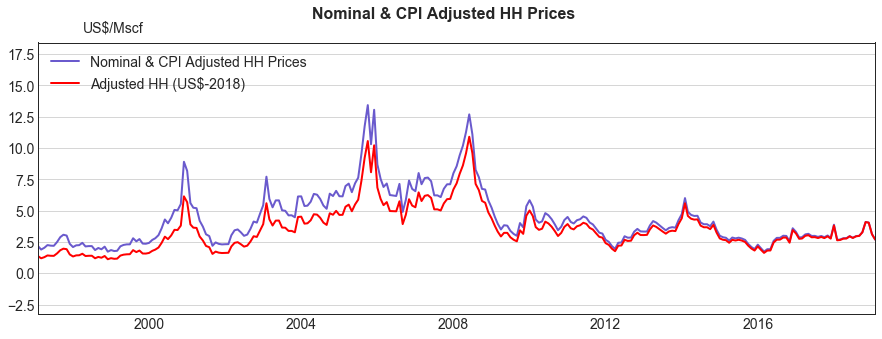

In [3]:
series_id_price = "NG.RNGWHHD.D" #HH

lx_hh_d, ly_hh_d, title_hh_d, country_hh_d, unit_hh_d = f_EIA_ExtractData(url,eia_api_key,series_id_price)
#convert output to a dictionary
d_hh = {
    "Date": lx_hh_d,
    "HH Price":ly_hh_d
}

#convert the dictionary to a dataframe 
df_hh = pd.DataFrame(d_hh)
# making the date column a panda date variable
df_hh["Date"]= pd.to_datetime(df_hh['Date'])

#convert the daily data to monthly data (Aggregation helps to reduce volatility !!!!!!!!)
df_hh = df_hh.set_index('Date')
df_hh_m = df_hh.resample('MS').mean()
df_hh_m.reset_index(inplace=True)

# converting panda date type to object
for index, row in df_hh_m.iterrows():
    str_date = str(row["Date"].year) + "-" + str(row["Date"].month) + "-" + str(row["Date"].day)
    df_hh_m.loc[index,"Date_1"] = datetime.strptime(str_date,'%Y-%m-%d').date()
del df_hh_m['Date']
df_hh_m = df_hh_m.rename(columns={'Date_1': 'Date'})

#Obtaining the CPI values
file = "CPIAUCSL.csv"
df_cpi = pd.read_csv(file)
# making the date column a panda date variable
df_cpi["DATE"]= pd.to_datetime(df_cpi['DATE'])

df_cpi = df_cpi.rename(columns={'DATE': 'Date',"CPIAUCSL" :"CPI"})

# converting panda date type to object
for index, row in df_cpi.iterrows():
    str_date = str(row["Date"].year) + "-" + str(row["Date"].month) + "-" + str(row["Date"].day)
    df_cpi.loc[index,"Date_1"] = datetime.strptime(str_date,'%Y-%m-%d').date()
del df_cpi['Date']
df_cpi = df_cpi.rename(columns={'Date_1': 'Date'})

#Creating a dataframe that storage info related to HH
df_HH = df_hh_m.merge(df_cpi,on="Date",how="inner")

# Correcting HH prices by inflation using CPI - the objective is to convert prices to US$ 2018
maxDate = df_HH["Date"].max()
updCPI = df_HH.loc[df_HH["Date"]==maxDate,"CPI"]
updCPI=min(updCPI)
df_HH["CPI-2018"] = df_HH["CPI"]*1/updCPI
df_HH["HH Price Upd"] = df_HH["HH Price"]*df_HH["CPI-2018"]

#Creating the log Prices columns
df_HH["Log HH Price"] = np.log(df_HH["HH Price"])
df_HH["Log HH Price Upd"] = np.log(df_HH["HH Price Upd"])

#Creating Columns with shift
df_HH["Log HH Price Upd Shift 1"] = df_HH["Log HH Price Upd"].shift()
df_HH["Log HH Price Shift 1"] = df_HH["Log HH Price"].shift()
df_HH=df_HH.dropna()

#Ploting HH and adjusted HH Prices
title = "Nominal & CPI Adjusted HH Prices"
unit = "US$/Mscf"
fig, ax = f_PlotData(df_HH["Date"],df_HH["HH Price"], title, unit)
ax.plot(df_HH["Date"],df_HH["HH Price Upd"], linewidth=2,color="red",label="Adjusted HH (US$-2018)")
ax.legend(loc='upper left')
plt.savefig(FileName)
FileName = "Figures-Presentation/" + title + ".png"
plt.show()

In [4]:
ini_date = "2006-1-1"; end_date = "2018-12-31"

series_id = Volume_series_id[0]
x_prod, y_prod, title_prod, country_prod, unit_prod = f_EIA_ExtractData_Range(url,eia_api_key,series_id,ini_date,end_date)

series_id = ImpEx_series_id[0]
x_imp, y_imp, title_imp, country_imp, unit_imp = f_EIA_ExtractData_Range(url,eia_api_key,series_id,ini_date,end_date)

series_id = ImpEx_series_id[1]
x_exp, y_exp, title_exp, country_exp, unit_exp = f_EIA_ExtractData_Range(url,eia_api_key,series_id,ini_date,end_date)

#Capacity, working gas, witdrawals

series_id = Storage_series_id[0] #Capacity
x_stocap, y_stocap, title_stocap, country_stocap, unit_stocap = f_EIA_ExtractData_Range(url,eia_api_key,series_id,ini_date,end_date)

#series_id = Storage_series_id[1]
#x_sto, y_sto, title_sto, country_sto, unit_sto = f_EIA_ExtractData_Range(url,eia_api_key,series_id,ini_date,end_date)

series_id = Storage_series_id[1] # Working Gas
x_wg, y_wg, title_sto, country_sto, unit_sto = f_EIA_ExtractData_Range(url,eia_api_key,series_id,ini_date,end_date)

series_id = Storage_series_id[2] # Widrawals
x_wit, y_wit, title_wit, country_wit, unit_wit = f_EIA_ExtractData_Range(url,eia_api_key,series_id,ini_date,end_date)

series_id = Volume_series_id[1]
x_com, y_com, title_com, country_com, unit_com = f_EIA_ExtractData_Range(url,eia_api_key,series_id,ini_date,end_date)

y_price = []
for i in range(0,len(x_prod),1):
        HH_Price_Upd = min(df_HH.loc[df_HH["Date"]==x_prod[i],"HH Price Upd"])
        y_price.append(HH_Price_Upd)

dict_data = {
    "Price": y_price,
    "Production": y_prod,    
    "Import": y_imp,
    "Export": y_exp,
    "Storage Capacity": y_stocap,    
    "Comsumption": y_com,
    #"Widrawals": y_wit,
    #"Working Gas": y_wg
}

df_data = pd.DataFrame(dict_data)

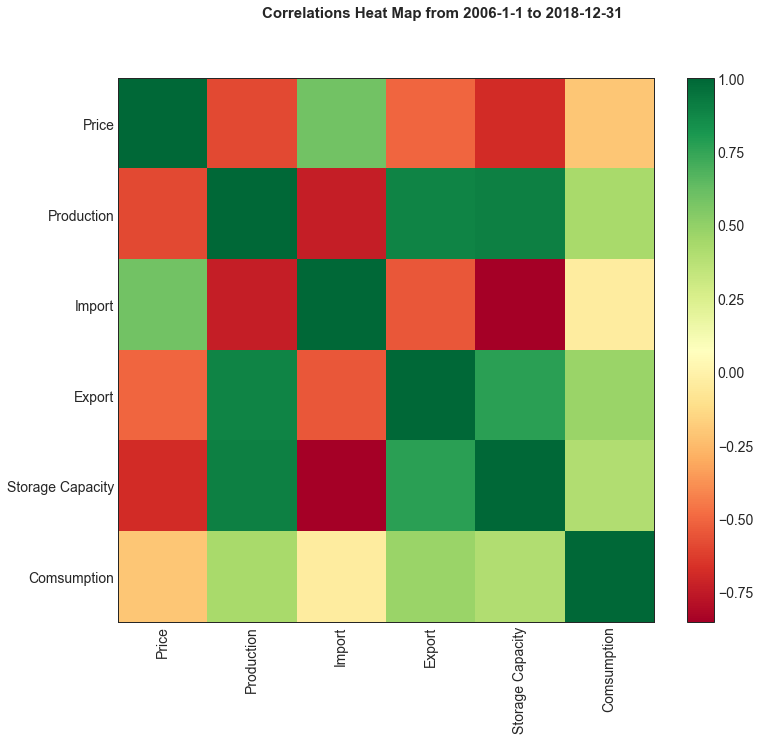

In [5]:
#Compute Correlation
corr = df_data.corr()

#Plot Correlation Matrix using Matplotlib
#%pylab inline
plt.figure(figsize=(12, 10))
plt.imshow(corr, cmap='RdYlGn', interpolation='none', aspect='auto')
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns, rotation='vertical')
plt.yticks(range(len(corr)), corr.columns);
str_Title = 'Correlations Heat Map from ' + ini_date + ' to ' + end_date
plt.suptitle(str_Title, fontsize=15, fontweight='bold')
FileName ="Figures-Presentation/" + str_Title + ".png"
plt.savefig(FileName)
plt.show()

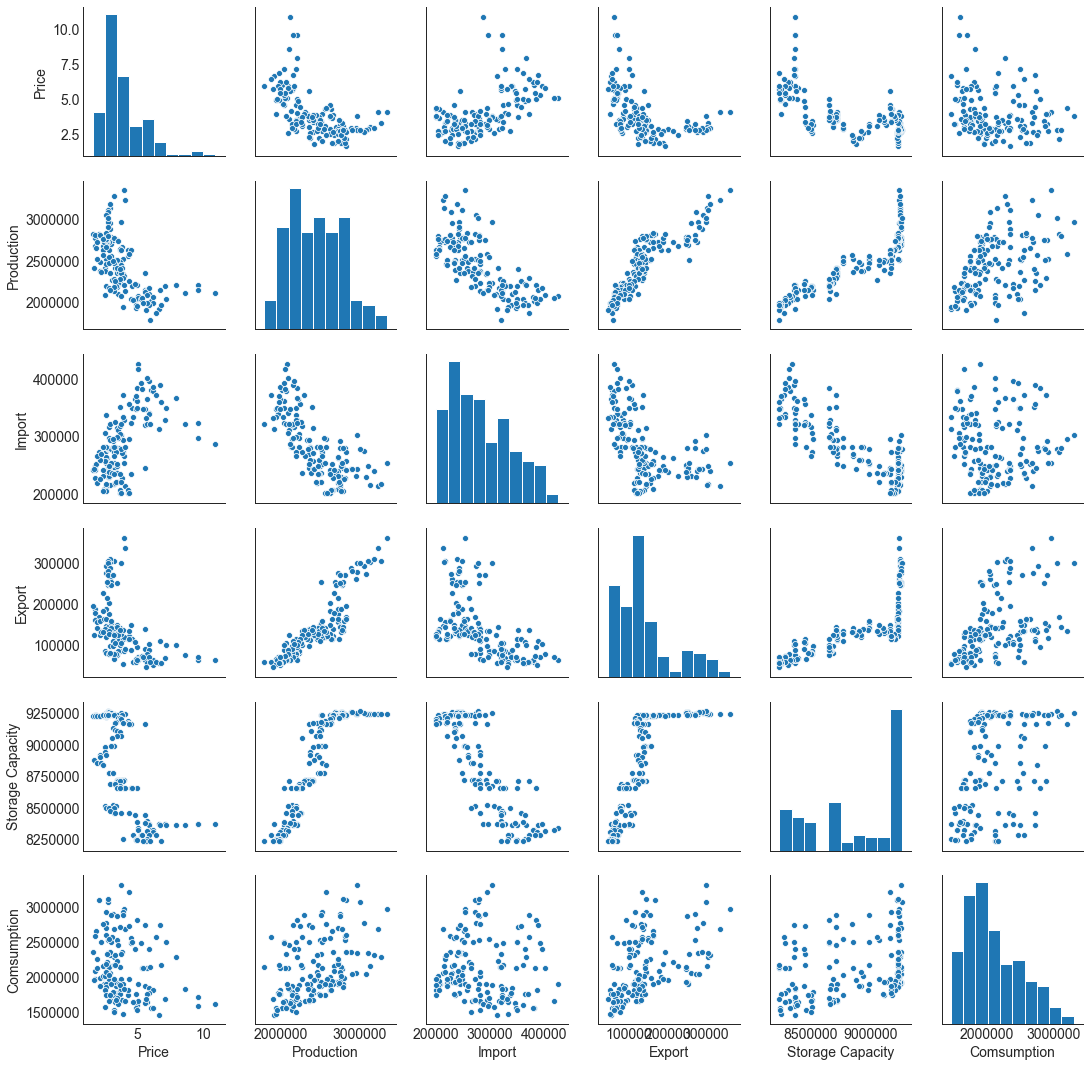

In [9]:
sns.pairplot(df_data)
str_Title = "Pairplot"
FileName ="Figures-Presentation/" + str_Title + ".png"
plt.savefig(FileName)
plt.show()

In [7]:
model = sm.OLS(df_data["Price"], df_data[["Production","Comsumption","Import","Export"]]).fit()
R2 = model.rsquared
pp = model.pvalues
print(model.params)
R2 = model.rsquared
pp = model.pvalues
model.summary()

Production     3.015834e-07
Comsumption   -3.093746e-07
Import         1.569861e-05
Export        -4.782708e-06
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.911
Model:                            OLS   Adj. R-squared:                  0.909
Method:                 Least Squares   F-statistic:                     390.7
Date:                Thu, 28 Mar 2019   Prob (F-statistic):           7.41e-79
Time:                        14:02:31   Log-Likelihood:                -255.48
No. Observations:                 156   AIC:                             519.0
Df Residuals:                     152   BIC:                             531.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Production   3.016e-07   3.06e-07      0.985      0.326   -3.03e-07    9.06e-07
Comsumption -3.094e-07   2.91e-07     -1.063      0.289   -8.84e-07    2.66e-07
Import        1.57e-05   1.73e-06      9.055      0.000    1.23e-05    1.91e-05
Export      -4.783e-06   2.44e-06     -1.962      0.052    -9.6e-06    3.42e-08
==============================================================================
Omnibus:                       81.343   Durbin-Watson:                   0.262
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              375.449
Skew:                           1.933   Prob(JB):                     2.97e-82
Kurtosis:                       9.543   Cond. No.                         90.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

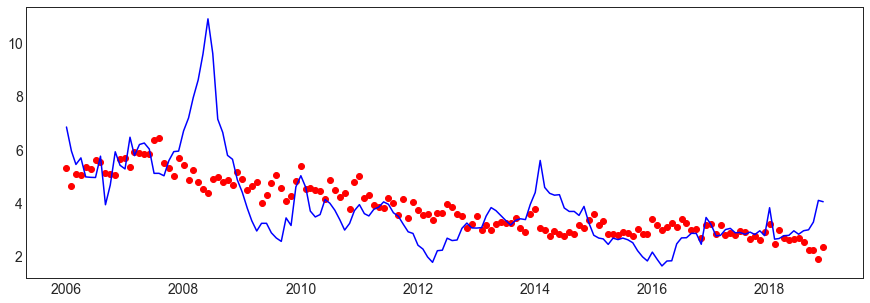

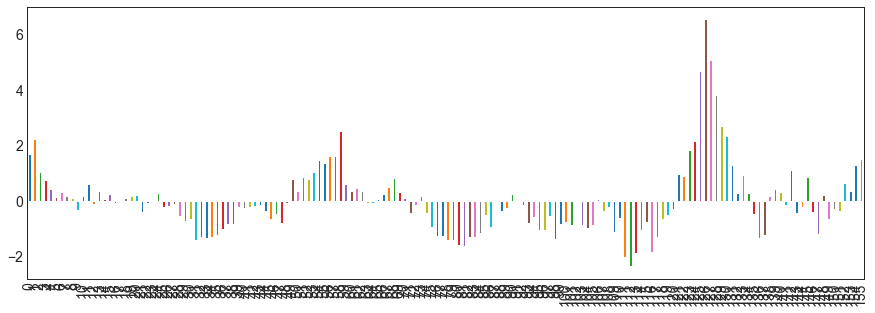

In [8]:
model_pred = model.predict()
x_prod
plt.scatter(x_prod,model_pred,c="r")
plt.plot(x_prod,df_data["Price"],c="b")
plt.show()
model.resid.plot(kind="bar")